<a href="https://colab.research.google.com/github/karankrish/OpnX/blob/master/kennedy_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **KENNEDY TECHNICAL TASK**

---






### Insallation of package

In [1]:
! pip install -q transformers
! pip install -q sentencepiece
! pip install -q tqdm
! pip install -q tensorflow_addons

     |████████████████████████████████| 4.7 MB 4.4 MB/s 
     |████████████████████████████████| 596 kB 57.8 MB/s 
     |████████████████████████████████| 101 kB 3.0 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
     |████████████████████████████████| 1.2 MB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


### Importing required python packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import zipfile
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import tensorflow_addons as tfa
from sklearn.metrics import  roc_curve, confusion_matrix,f1_score,auc
import matplotlib.pyplot as plt
from itertools import cycle
from keras.models import load_model

### Load Data into Colab

Upload bbc.zip file from your machine

In [3]:
uploaded = files.upload()

Saving bbc.zip to bbc.zip


###Data Extraction

In [4]:
with zipfile.ZipFile('bbc.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
def readData(path):
    file = open(path,"r",errors='ignore')
    file = file.readlines()
    file = [value for value in file if value != "\n"]
    file = " ".join(file)
    file = file.replace("\n","")
    return file

In [6]:
os.chdir('bbc/')
data = []
for dirname, _, filenames in os.walk("."):
    if dirname in ['./business','./entertainment','./politics','./sport','./tech']:
        print(dirname)
        for filename in filenames:
            jsonData={}
            jsonData['txtData'] = readData(os.path.join(dirname, filename))
            jsonData['label'] = dirname.replace("./","")
            data.append(jsonData)

./tech
./sport
./politics
./business
./entertainment


In [7]:
df = pd.DataFrame(data)

In [8]:
df.head()

,txtData,label
0,Musical future for phones Analyst Bill Thompso...,tech
1,"Lifestyle 'governs mobile choice' Faster, bett...",tech
2,Halo 2 sells five million copies Microsoft is ...,tech
3,Tough rules for ringtone sellers Firms that fl...,tech
4,Hotspot users gain free net calls People using...,tech


### Data Analysis

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   txtData  2225 non-null   object
 1   label    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


Data set size is to small 2225 records. So transfer leaning is best solution 

Lets find out median word count in the record 

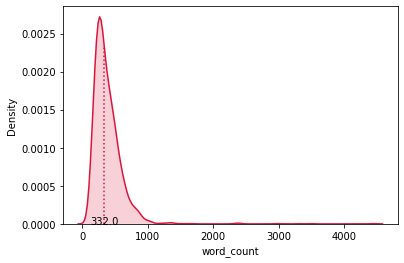

In [10]:
df['word_count'] = df['txtData'].apply(lambda x: len(x.split()))  
ax = sns.kdeplot(df['word_count'], shade=False, color='crimson')
kdeline = ax.lines[0]
median = df['word_count'].median()
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(median, xs, ys)
ax.vlines(median, 0, height, color='crimson', ls=':')
ax.text(median,0, median,ha='center')
ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
plt.show()

Median count is 332, there are few records with more than 1000 word count. So let take maximum word count to do model as 332 word

Let find out distribution of label (target varible)

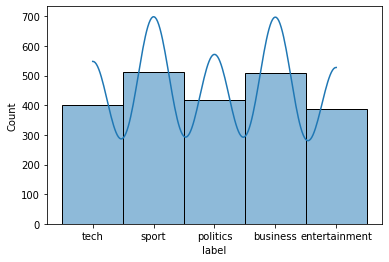

In [11]:
sns.histplot(data = df['label'], kde = True)

As we can see the data is blanced. So we can consider accuracy and F1 score as model performance metrics

### Data Preprocessing

In [12]:
label_encoder = preprocessing.LabelEncoder()
df['label']= label_encoder.fit_transform(df['label'])

In [13]:
Class = 5

In [14]:
labels = np.zeros((len(df), Class))
labels.shape

(2225, 5)

In [15]:
labels[np.arange(len(df)), df['label'].values] = 1

In [16]:
labels

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Split data into 70% for training and rest 30% for testing 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.3, random_state=42)

### Model building

**Why BERT?**


*   It is based on transformers
*   It can learns contextual relations between words or sub-words in a text.
*   It is bidirectional.
*   Faster than RNN-based models as all the input is consume once.
*   Training BERT is easy when compared with  LSTMs.
*   LSTM networks are impossible to do transfer learning.
*   Good for parallel computing

**Why Not GPT-3?**

*  It is unidirectional
*  Large model size and need more resource 

**bert-base-cased** is a pretrained model on English language using a masked language modeling (MLM) objective. This model is case-sensitive it makes a difference between english and English.

In [18]:
# Initialize the model name, max length as the median length in the given data set and batch size. 
MODEL_NAME = 'bert-base-cased'
WORD_LENGHT = 332
BATCH_SIZE = 16 

loading bert tokenizer of 'bert-base-cased' 

In [19]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [20]:
#Initialize X_input_ids and X_attn_masks
X_input_ids = np.zeros((len(X_train), WORD_LENGHT))
X_attn_masks = np.zeros((len(X_train), WORD_LENGHT))

In [21]:
def generateData(X_train, ids, masks, tokenizer):
    for i, text in enumerate(X_train['txtData']):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=WORD_LENGHT, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [22]:
X_input_ids, X_attn_masks = generateData(X_train, X_input_ids, X_attn_masks, tokenizer)

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, y_train))

In [24]:
def DatasetMap(input_ids, attn_masks, y_train):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, y_train

In [25]:
dataset = dataset.map(DatasetMap) 

In [26]:
dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True) 

Create a validation set so that validate our model performance during training

In [27]:
p = 0.75
train_size = int((len(X_train)//BATCH_SIZE)*p)
val_dataset = dataset.skip(train_size)
train_dataset = dataset.take(train_size)


In [28]:
print(len(train_dataset))
print(len(val_dataset))

72
25


Loading pretrained model

In [29]:
model = TFBertModel.from_pretrained(MODEL_NAME)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
input_ids = tf.keras.layers.Input(shape=(WORD_LENGHT,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(WORD_LENGHT,), name='attention_mask', dtype='int32')

bert_embds_layer = model.bert(input_ids, attention_mask=attn_masks)[1]
layer1 = tf.keras.layers.Dense(256, activation='relu',kernel_constraint=tf.keras.constraints.MaxNorm(3), name='layer1')(bert_embds_layer)
dropout = tf.keras.layers.Dropout(0.2)(layer1)
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(dropout) 
classify_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
classify_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 332)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 332)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 332,                                           

Regularization used:

MaxNorm - penalize high weights with your loss function

dropout - during the training phase of certain set of neurons which is chosen at random

In [31]:
# Initialize parameter for model training
learningRate=1e-5
Decay=1e-6
EPOCH=5

**Why Adam optimizer?** 

Adam optimization algorithm is a further extension of stochastic gradient descent to update network weights during training. It updates the learning rate for each network weight individually.  It inherits the features of both Adagrad and RMS prop algorithms. In adam, instead of adapting learning rates based upon the first moment as in RMS Prop, it also uses the second moment of the gradients.

Adam optimizer are generally better than other optimization algorithms, have a faster computation time, and require fewer parameters for tuning

In [32]:
optim = tf.keras.optimizers.Adam(learning_rate=learningRate, decay=Decay)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
f1score = tfa.metrics.F1Score(num_classes=Class)

Since the classes are not mutually exclusive CategoricalAccuracy is good metrics.

High F1 score means less False Positive and False Negative

In [33]:
classify_model.compile(optimizer=optim, loss=loss_func, metrics=[acc,f1score])

In [34]:
hist = classify_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
72/72 [==============================] - 104s 1s/step - loss: 1.2049 - accuracy: 0.4878 - f1_score: 0.4817 - val_loss: 0.3960 - val_accuracy: 0.9325 - val_f1_score: 0.9295
Epoch 2/5
72/72 [==============================] - 94s 1s/step - loss: 0.2523 - accuracy: 0.9497 - f1_score: 0.9498 - val_loss: 0.0713 - val_accuracy: 0.9875 - val_f1_score: 0.9872
Epoch 3/5
72/72 [==============================] - 95s 1s/step - loss: 0.0839 - accuracy: 0.9870 - f1_score: 0.9868 - val_loss: 0.0398 - val_accuracy: 0.9925 - val_f1_score: 0.9921
Epoch 4/5
72/72 [==============================] - 96s 1s/step - loss: 0.0606 - accuracy: 0.9905 - f1_score: 0.9908 - val_loss: 0.0229 - val_accuracy: 0.9975 - val_f1_score: 0.9977
Epoch 5/5
72/72 [==============================] - 96s 1s/step - loss: 0.0527 - accuracy: 0.9861 - f1_score: 0.9860 - val_loss: 0.0121 - val_accuracy: 0.9975 - val_f1_score: 0.9974


In [35]:
# saving model
classify_model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


### Evaluating Learning

Training and validation Loss with reference to epoch

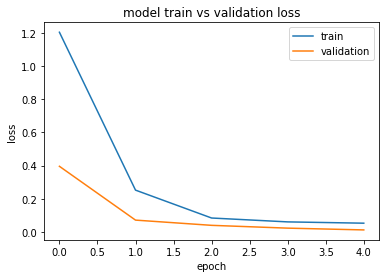

In [36]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Training and validation Accuracy with reference to epoch

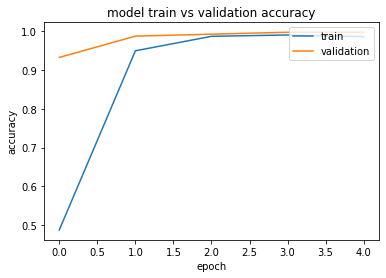

In [37]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Training and validation F1score with reference to epoch

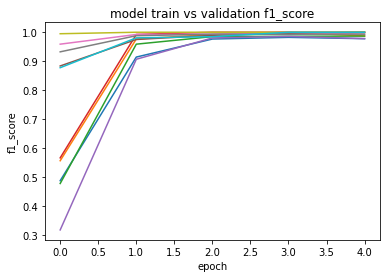

In [38]:
plt.plot(hist.history['f1_score'])
plt.plot(hist.history['val_f1_score'])
plt.title('model train vs validation f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.show()

Evaluating Model

Preporocess data

In [39]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

X_input_ids = np.zeros((len(X_test), WORD_LENGHT))
X_attn_masks = np.zeros((len(X_test), WORD_LENGHT))

def generateData(X_test, ids, masks, tokenizer):
    for i, text in enumerate(X_test['txtData']):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=WORD_LENGHT, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

X_input_ids, X_attn_masks = generateData(X_test, X_input_ids, X_attn_masks, tokenizer)
test_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, y_test))

def DatasetMapFunction(input_ids, attn_masks, y_test):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    },y_test

test_dataset = test_dataset.map(DatasetMapFunction) 
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [40]:
pred = classify_model.predict(test_dataset)

In [41]:
len(pred)

656

In [42]:
y_test=y_test[:656]

### ROC CURVE

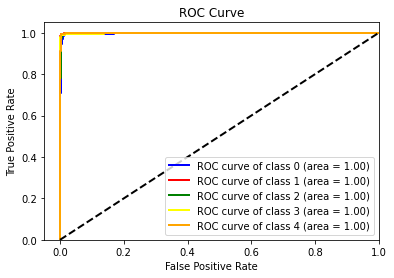

In [43]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','yellow','orange','pink'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Load saved model

In [44]:
Tmodel = load_model("model",compile=False)

Zip and download model

In [45]:
!zip -r model.zip model/ 

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 92%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: model/variables/variables.index (deflated 80%)
  adding: model/keras_metadata.pb (deflated 95%)
  adding: model/assets/ (stored 0%)
